In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

root_dir = '/content/gdrive/MyDrive/Data'

Mounted at /content/gdrive


In [2]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from pandas.core.frame import DataFrame
from time import sleep
import math

Extracting labelled and unlabelled dataset

In [3]:
participants = 1
experience = 8

psg_dir = os.path.join(root_dir, "18 participants/PSG")
features_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))

# PSG Files
PSG_Consensus_Sleep_profile = "SDRI001_PSG_Consensus Sleep profile_0"
PSG_Heart_Rate = "SDRI001_PSG_Heart Rate_0"
PSG_HRV_HF = "SDRI001_PSG_HRV HF_0"
PSG_HRV_LF = "SDRI001_PSG_HRV LF_0"
PSG_Position = "SDRI001_PSG_Position_0"
PSG_RR_Interval = "SDRI001_PSG_RR-Interval_0"
PSG_SpO2 = "SDRI001_PSG_SpO2_0"

def get_PSG_dataset(PSF_DIR, PSG_File, participant):
  file_name = os.path.join(PSF_DIR, PSG_File + str(participant).zfill(2) + "V4_N1.txt")
  dataset = pd.read_csv(file_name, sep=" ")
  return dataset

def reformatPSGDatetime(date, time):
  #File 9 Anamoly
  if not isinstance(date, str):
    after_midnight = 0
    if int(time[:2]) < 22:
      after_midnight = 1
    date = str(26+after_midnight) + ".02.2020"

  date = date.split('.')
  time = time.split(',')[0]
  datetime = date[2] + '-' + date[1] + '-' + date[0] + ' ' + time
  return datetime

def extractSleepProfileLabels(dataset, starting_rows=5):
  columns = np.array(dataset.columns)
  columns[0] = 'Date'
  columns[1] = 'Time'
  columns[2] = 'Sleep State'
  dataset.columns = columns
  dataset = dataset.iloc[starting_rows:]
  dataset['Label'] = dataset.apply(lambda x: reformatPSGDatetime(x['Date'], x['Time']), axis=1)
  dataset = dataset[['Label', 'Sleep State']]
  return dataset

def extractNonSleepProfileLabels(dataset, starting_rows=5):
  columns = np.array(dataset.columns)
  columns[0] = 'Date'
  columns[1] = 'Time'
  columns[2] = 'Value'
  columns[3] = 'Sleep State'
  #File 9 Anamoly
  if ',' in dataset.iloc[starting_rows][0]:
    columns[0] = 'Time'
    columns[1] = 'Value'
    columns[2] = 'Sleep State'
    columns[3] = 'Date'
    dataset.columns = columns
    print(dataset.iloc[starting_rows]['Date'])

  dataset.columns = columns
  dataset = dataset.iloc[starting_rows:]
  dataset['Label'] = dataset.apply(lambda x: reformatPSGDatetime(x['Date'], x['Time']), axis=1)
  dataset = dataset[['Label', 'Value', 'Sleep State']]
  return dataset

def get_Features_dataset(features_dir, file="Features.pkl"):
  file_name = os.path.join(features_dir, file)
  dataset = pd.read_pickle(file_name)
  return dataset

def getSection(features_dir):
  file_name = os.path.join(features_dir, "Sections.pkl")
  dataset = pd.read_pickle(file_name)
  dataset = np.array(dataset)
  return dataset.reshape(dataset.shape[0])

def get_Feature_Dataset(sections, features_dataset, participant):
  from_idx = sections[participant-1]
  to_idx = sections[participant]
  return features_dataset.iloc[from_idx:to_idx]

def extract_unlabelled_dataset(feature_dataset, psg_dataset):
  feature_dataset = pd.merge(feature_dataset, psg_dataset, how='left', on="Label")
  return feature_dataset[feature_dataset['Sleep State'].isnull()]

def SaveDataset(dataset, file_name):
  save_file = os.path.join(features_dir, file_name)
  dataset.to_pickle(save_file)

features_dataset = get_Features_dataset(features_dir, "Raw.pkl")
sections = getSection(features_dir)

Extracting labels of Heart rate and Positions dataset


In [4]:
psg_dataset = get_PSG_dataset(psg_dir, PSG_Heart_Rate, 1)
psg_dataset = psg_dataset.reset_index()
psg_dataset = extractNonSleepProfileLabels(psg_dataset, 6)
feature_dataset = get_Feature_Dataset(sections, features_dataset, 1)

labelled_dataset = pd.merge(feature_dataset, psg_dataset, on="Label")
unlabelled_dataset = extract_unlabelled_dataset(feature_dataset, psg_dataset)

for participant in range(2, participants + 1):
  psg_dataset = get_PSG_dataset(psg_dir, PSG_Heart_Rate, participant)
  psg_dataset = psg_dataset.reset_index()
  print(psg_dataset.shape)

  psg_dataset = extractNonSleepProfileLabels(psg_dataset, 6)
  feature_dataset = get_Feature_Dataset(sections, features_dataset, participant)

  new_labelled_dataset = pd.merge(feature_dataset, psg_dataset, on="Label")
  new_unlabelled_dataset = extract_unlabelled_dataset(feature_dataset, psg_dataset)

  labelled_dataset = labelled_dataset.append(new_labelled_dataset, ignore_index=True)
  unlabelled_dataset = unlabelled_dataset.append(new_unlabelled_dataset, ignore_index=True)

SaveDataset(labelled_dataset, "RawLabelledHR")
SaveDataset(unlabelled_dataset, "RawUnlabelledHR")

print(feature_dataset.shape)
print(labelled_dataset.shape)
print(unlabelled_dataset.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(29620, 903)
(1199, 905)
(28421, 905)


Extracting labels of Sleep profile dataset

In [5]:
psg_dataset = get_PSG_dataset(psg_dir, PSG_Consensus_Sleep_profile, 1)
psg_dataset = extractSleepProfileLabels(psg_dataset)
feature_dataset = get_Feature_Dataset(sections, features_dataset, 1)

labelled_dataset = pd.merge(feature_dataset, psg_dataset, on="Label")
unlabelled_dataset = extract_unlabelled_dataset(feature_dataset, psg_dataset)

for participant in range(2, participants + 1):
  psg_dataset = get_PSG_dataset(psg_dir, PSG_Consensus_Sleep_profile, participant)
  psg_dataset = extractSleepProfileLabels(psg_dataset)
  feature_dataset = get_Feature_Dataset(sections, features_dataset, participant)

  new_labelled_dataset = pd.merge(feature_dataset, psg_dataset, on="Label")
  new_unlabelled_dataset = extract_unlabelled_dataset(feature_dataset, psg_dataset)

  labelled_dataset = labelled_dataset.append(new_labelled_dataset, ignore_index=True)
  unlabelled_dataset = unlabelled_dataset.append(new_unlabelled_dataset, ignore_index=True)

SaveDataset(labelled_dataset, "RawLabelled")
SaveDataset(unlabelled_dataset, "RawUnlabelled")

print(psg_dataset.shape)
print(feature_dataset.shape)
print(labelled_dataset.shape)
print(unlabelled_dataset.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(1201, 2)
(29620, 903)
(1201, 904)
(28419, 904)


PseudoLabeling module

In [ ]:
experience = 8

features_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
file_name = os.path.join(features_dir, "RawLabelled")

def encode_sleep_stage(val):
  arr = {'N1':0, 'N2':1, 'N3':2, 'REM':3, 'Wake':4, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

def encode_sleep_state(val):
  arr = {'N1':0, 'N2':1, 'N3':2, 'REM':3, 'Wake':4, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

dataset = pd.read_pickle(file_name)
dataset['Sleep State'] = dataset['Sleep State'].apply(lambda x: encode_sleep_stage(x))
dataset['Sleep State'] = pd.Series(np.array(dataset['Sleep State'])).interpolate()
dataset['Sleep State'] = np.array(dataset['Sleep State'].replace(to_replace = np.nan, value=4), dtype=np.int64)

In [ ]:
def train_test_split(dataset, test_train_ratio, number_bags=10):
  dataset_bag_size = int(dataset.shape[0]/number_bags)
  separation_point = int(dataset_bag_size * test_train_ratio)
  dataset_split = dataset[:dataset_bag_size]
  dataset_train = dataset_split[:separation_point]
  dataset_test = dataset_split[separation_point:]

  for i in range(1, number_bags):
    dataset_split = dataset[i*dataset_bag_size:dataset_bag_size * (i+1)]
    new_dataset_train = dataset_split[:separation_point]
    new_dataset_test = dataset_split[separation_point:]
    dataset_train = dataset_train.append(new_dataset_train, ignore_index = True)
    dataset_test = dataset_test.append(new_dataset_test, ignore_index = True)

  return dataset_train, dataset_test

def train_test_split_rand(dataset, test_train_ratio):
  n = dataset.shape[0]
  split_point = int((1-test_train_ratio) * n)
  randIdx_test = random.sample(range(0, dataset.shape[0]), split_point)
  randIdx_train = np.setdiff1d(range(0, dataset.shape[0]), randIdx_test)

  dataset_train = dataset.iloc[randIdx_train]
  dataset_test = dataset.iloc[randIdx_test]
  return dataset_train, dataset_test


print(dataset.shape)
train_test_ratio = 0.9

dataset_size = dataset.shape[0]
split_point = int(train_test_ratio * dataset_size)

labels = np.array(dataset['Sleep State'])
dataset_train = dataset.drop(['Label','Sleep State'], axis=1)

#x_train = dataset_train[:split_point]
#x_test = dataset_train[split_point:]
#y_train = labels[:split_point]
#y_test = labels[split_point:]

#x_train, x_test = train_test_split(dataset, train_test_ratio, number_bags=1500)
x_train, x_test = train_test_split_rand(dataset, train_test_ratio)

y_train = np.array(x_train['Sleep State'])
y_test = np.array(x_test['Sleep State'])

x_train = x_train.drop(['Label','Sleep State'], axis=1)
x_test = x_test.drop(['Label','Sleep State'], axis=1)

print(x_train.shape)
print(y_train.shape)


(1201, 904)
(1081, 902)
(1081,)


[link text]Gradient Boosting Trees



(1920, 8)
[[ 56  85   0  12  51]
 [ 41 557  22   7  21]
 [  2  41 241   2   5]
 [ 12  20   1 158   1]
 [ 42  50   3  10 480]]
Precision, Recall and F1 Score for N1 are 0.37, 0.27, 0.31
Precision, Recall and F1 Score for N2 are 0.74, 0.86, 0.8
Precision, Recall and F1 Score for N3 are 0.9, 0.83, 0.86
Precision, Recall and F1 Score for REM are 0.84, 0.82, 0.83
Precision, Recall and F1 Score for Wake are 0.86, 0.82, 0.84
(5, 5)
Accuracy is 0.78


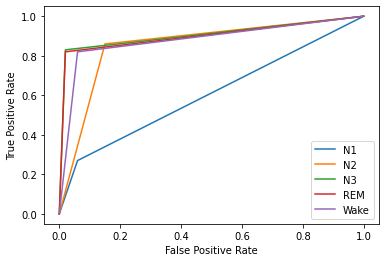

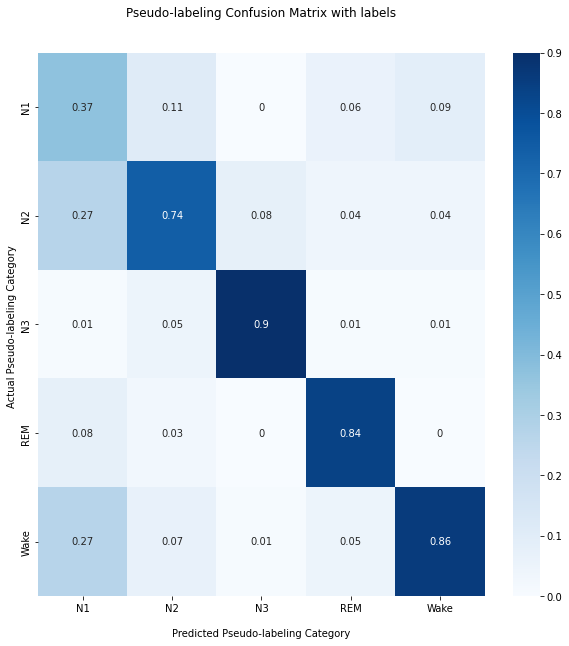

([0.37, 0.74, 0.9, 0.84, 0.86], 0.78)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

print(x_test.shape)

#test_labels_single = list(map(convertMultiLabelToSingleLabel, test_labels))
#print(test_labels.value_counts())

rf_model = GradientBoostingClassifier(n_estimators=400, learning_rate=0.6)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)

Labels = ['N1','N2', 'N3', 'REM', 'Wake']

printConfusionMatrix(y_test, y_pred, Labels, show=True)

Random Forest Model

[[ 5  3  0  0  2]
 [ 1 22  1  7  4]
 [ 0  0 18  0  0]
 [ 0  0  0 19  0]
 [ 2  0  0  0 36]]
Precision, Recall and F1 Score for N1 are 0.62, 0.5, 0.55
Precision, Recall and F1 Score for N2 are 0.88, 0.63, 0.73
Precision, Recall and F1 Score for N3 are 0.95, 1.0, 0.97
Precision, Recall and F1 Score for REM are 0.73, 1.0, 0.84
Precision, Recall and F1 Score for Wake are 0.86, 0.95, 0.9
(5, 5)
Accuracy is 0.83
Performance is 0.81


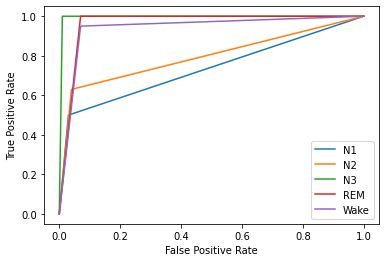

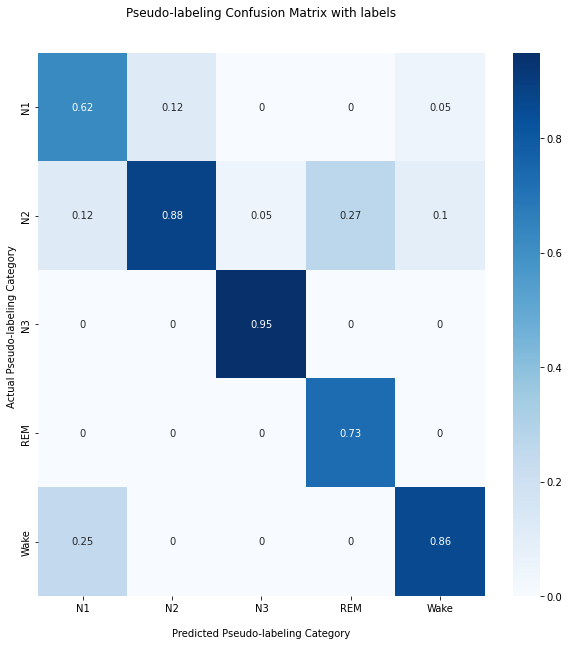

([0.62, 0.88, 0.95, 0.73, 0.86], 0.83)

In [ ]:
from keras.callbacks import learning_rate_schedule
from sklearn.ensemble import RandomForestClassifier

#test_labels_single = list(map(convertMultiLabelToSingleLabel, test_labels))
#print(test_labels.value_counts())

rf_model = RandomForestClassifier(bootstrap=True,
                                  #max_features = 'sqrt',
                                  n_estimators=1500)

rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)

Labels = ['N1','N2', 'N3', 'REM', 'Wake']

printConfusionMatrix(y_test, y_pred, Labels)

CNN Module

In [ ]:
n = dataset.shape[0]
train_ratio = 0.9
separate_id = int(n * train_ratio)

labels = np.zeros((n,5))

for i in range(n):
  label = dataset.iloc[i]['Sleep State']
  labels[i][label] = 1

print(dataset['Sleep State'].value_counts())
dataset = dataset.drop(['Label', 'Sleep State'], axis=1)
dataset += 0.001
dataset = np.array(dataset)

dataset = dataset.reshape((dataset.shape[0], dataset.shape[1], 1, 1))

x_train = dataset[:separate_id]
y_train = labels[:separate_id]

x_test = dataset[separate_id:]
y_test = labels[separate_id:]

print(dataset.shape)
#print(dataset[0])
print(labels.shape)

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
#create model
model = Sequential()
#add model layers
model.add(Conv2D(8, kernel_size=(1,1), activation='relu', input_shape=(dataset.shape[1],1,1)))
#model.add(MaxPooling2D((1,1)))
model.add(Flatten())
model.add(Dense(6, activation='sigmoid'))
model.add(Dense(5, activation='softmax'))

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(learning_rate=0.01)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.003, epsilon=0.01)
model.compile(optimizer=rms,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=1 ,validation_data=(x_test, y_test), epochs=50)

def plot_graph(x, y, z, x_label, y_label, legends, figsize=(7,7)):
  plt.plot(z, x, 'r--')
  plt.plot(z, y, 'b-')
  plt.legend(legends)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.figure(figsize=figsize)
  plt.show();

history = model.history

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Get training and test loss histories
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

plot_graph(training_loss, test_loss, epoch_count, 'Epoch', 'Loss', ['Training Loss', 'Test Loss'])
plot_graph(accuracy, val_accuracy, epoch_count, 'Epoch', 'Accuracy', ['Accuracy', 'Test Accuracy'])

test_labels = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)
Labels = ['N1','N2', 'N3', 'REM', 'Wake']

printConfusionMatrix(test_labels, y_pred, Labels, show=True)


1    6536
4    5670
2    2740
0    2140
3    2123
Name: Sleep State, dtype: int64
(19209, 47, 1, 1)
(19209, 5)
Epoch 1/50
 3100/17288 [====>.........................] - ETA: 20s - loss: 1.4612 - accuracy: 0.4100

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
from sklearn import metrics

#printConfusionMatrix(y_test, y_pred, Labels, show=True)

def printConfusionMatrix(test_labels, y_pred, Labels, show=True):
  cf_matrix = confusion_matrix(test_labels, y_pred)
  #cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
  
  print(cf_matrix)

  precisions = []
  recalls = []
  f1_scores = []
  FPRs = []
  n = len(test_labels)

  total_vals = 0
  tps = 0
  for i in range(cf_matrix.shape[0]):
    sum_vals = cf_matrix[i].sum()
    sum_cols = cf_matrix[:, i].sum()

    total_vals += sum_vals
    tps += cf_matrix[i][i]
    recall = round(cf_matrix[i][i]/sum_vals, 2)
    recalls.append(recall)
    precision = round(cf_matrix[i][i]/sum_cols, 2)
    precisions.append(precision)
    f1_score = round(2 * precision * recall / (recall + precision), 2)
    f1_scores.append(f1_score)

    # ROC
    TN = n - sum_vals - sum_cols + cf_matrix[i][i]
    FP = sum_cols - cf_matrix[i][i]
    FPR = round(FP / (FP + TN), 2)
    FPRs.append(FPR)
    if show:
      print("Precision, Recall and F1 Score for " + Labels[i] + " are " + str(precision) + ", " + str(recall) + ", " + str(f1_score))
      plt.plot([0,FPR, 1],[0,recall,1])

  accuracy = round(tps/total_vals, 2)
  performance = round((np.array(f1_scores).sum()+np.array(recalls).sum()+np.array(precisions).sum())/(3*len(Labels)), 2)

  cf_mat = np.zeros((cf_matrix.shape[0], cf_matrix.shape[0]))
  print(cf_mat.shape)
  for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[0]):
      cols_sum = cf_matrix[:,j].sum()
      cf_mat[i][j] = round(cf_matrix[i][j]/cols_sum, 2)

  if show:
    print("Accuracy is " + str(accuracy))
    print("Performance is " + str(performance))
    #plot_confusion_matrix(conf_mat=cf_matrix, show_normed=True, figsize=(7,7))

    #create ROC curve
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(Labels)
    plt.show()

    fig, siz = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', ax=siz)


    ax.set_title('Pseudo-labeling Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Pseudo-labeling Category')
    ax.set_ylabel('Actual Pseudo-labeling Category ');

    ## Ticket labels - List must be in alphabetical order

    ax.xaxis.set_ticklabels(Labels)
    ax.yaxis.set_ticklabels(Labels)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

  return precisions, accuracy

def get_n_rand_nums(start, end, totalNums):
  randIdx = random.sample(range(start, end), totalNums)
  randIdx.sort()
  return randIdx

# divides up the array to two arrays using the ids array
def separateArr(arr, ids):
  ids_id = 0
  part_1 = []
  part_2 = []

  print(arr.shape)

  for i in range(arr.shape[0]):
    row = arr[i]
    if ids_id < len(ids) and i == ids[ids_id]:
      part_2.append(row)
      ids_id += 1
    else:
      part_1.append(row)

  return np.array(part_1), np.array(part_2)